# Incorporating uncertainty

In this tutorial, we show how to quickly set up and train a CNN-based regression model including uncertainty with the deep4cast package. The goal is to highlight how adding uncertainty allows the addition of bounds on predictions. The example data constitutes of a monthly 26-dimensional multivariate time series.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
from deep4cast.metrics import *
from pandas import read_table, DataFrame

%matplotlib inline

/Users/shirleyren/Development/deep4cast/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

In [2]:
# Load the data from file
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')

In [3]:
df.head()

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,...,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26
0,36040,15638,27222,25913,8519,28579,7743,53479,23150,20541,...,16858,29794,13590,6170,43032,23503,16781,45631,190962,78455
1,33482,11215,15633,10033,19334,18288,13012,34481,13210,19592,...,12294,28157,14439,9776,38949,20674,16168,51139,191064,78708
2,47063,18169,24173,11797,35178,30419,32276,62232,23250,34700,...,16513,29039,18531,10928,44601,28843,24725,55172,197496,88227
3,49452,29184,33471,11012,22090,21563,13279,41370,23824,33162,...,19412,32026,13476,11378,39004,27524,21048,51784,213565,101566
4,46636,18623,30444,26261,41330,20669,7253,31857,17384,26630,...,19934,29836,13982,6023,31193,26607,25394,46748,183091,110900


In [4]:
# Set lookback window for truncated sample time series
lag = 20 # i.e. 20 months
test_fraction = 0.15
test_length = int(len(df) * test_fraction)
train_length = len(df) - test_length

# Prepare train and test set
ts = df.astype('float32').values
ts = np.expand_dims(ts, axis=-1)
ts_train = ts[:-test_length]
ts_test = ts[-test_length - lag:]

### Plot of the time series data

Text(0.5,1,'Black: training time series; Red: testing time series')

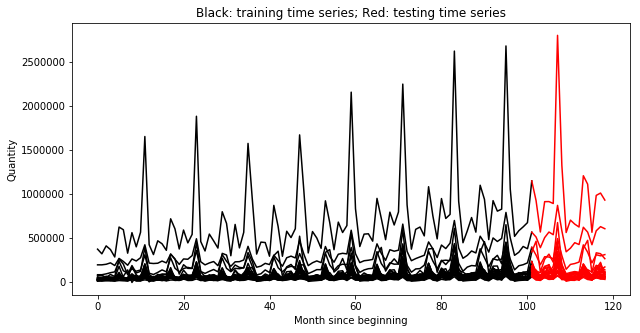

In [5]:
plt.figure(figsize=(10,5))
plt.plot(ts[:train_length,:,0], 'k')
plt.plot(range(len(ts[:train_length-1,:,0]), len(ts)), ts[train_length-1:,:,0], 'r')
plt.xlabel('Month since beginning')
plt.ylabel('Quantity')
plt.title('Black: training time series; Red: testing time series')

### Understand the metric MASE (Mean Absoluate Scaled Error)

In [6]:
# check naive case of MASE = 0: perfect prediction
freq = 12
print('TRAIN \t Mean Absolute Scaled Error: {0:.1f}%'.format(mase(ts[lag:train_length], ts[lag:train_length], ts_train, freq)))
print('TEST \t Mean Absolute Scaled Error: {0:.1f}%'.format(mase(ts[train_length:], ts[train_length:], ts_train, freq)))

TRAIN 	 Mean Absolute Scaled Error: 0.0%
TEST 	 Mean Absolute Scaled Error: 0.0%


In [7]:
# check naive case of MASE = 100%: prediction based on last year's observation.
print('TRAIN \t Mean Absolute Scaled Error: {0:.1f}%'.format(mase(ts_train[:-freq], ts_train[freq:], ts_train, freq)))
print('TEST \t Mean Absolute Scaled Error: {0:.1f}%'.format(mase(ts_test[:-freq], ts_test[freq:], ts_train, freq)))

TRAIN 	 Mean Absolute Scaled Error: 100.0%
TEST 	 Mean Absolute Scaled Error: 98.2%


## Temporal Convolutional Neural Network Forecaster with Uncertainty

We choose the temporal CNN, which uses one-dimensional convolutions for modeling purposes.

In [8]:
# Hyper-parameters
topology = [
    {
        'meta': {'layer_type': 'Conv1D', 'layer_id': 'c1', 'parent_ids': ['input']},
        'params': {'filters': 64, 'kernel_size': 5, 'activation': 'elu'}
    },
    {
        'meta': {'layer_type': 'Conv1D', 'layer_id': 'c2', 'parent_ids': ['c1']},
        'params': {'filters': 64, 'kernel_size': 3, 'activation': 'elu'}
    },
    {
        'meta': {'layer_type': 'Conv1D', 'layer_id': 'c3','parent_ids': ['c2']},
        'params': {'filters': 128, 'kernel_size': 3, 'activation': 'elu'}
    },
    {
        'meta': {'layer_type': 'Flatten', 'layer_id': 'f1', 'parent_ids': ['c3']},
        'params': {}
    },
    {
        'meta': {'layer_type': 'Dense', 'layer_id': 'd1', 'parent_ids': ['f1']
        },
        'params': {'units': 128, 'activation': 'elu'}
    },
    {
        'meta': {'layer_type': 'Dense', 'layer_id': 'd2', 'parent_ids': ['d1']},
        'params': {'units': 128, 'activation': 'elu'}
    }
]

# Instantiate regression model
epoch = 2500
dropout_rate = 0.1
forecaster = Forecaster(
    topology,
    optimizer='sgd',
    lag=lag,
    horizon=1,
    batch_size=8,
    epochs=epoch,
    uncertainty=True,
    dropout_rate = dropout_rate,
    lr=0.1
)
forecaster.fit(ts_train)

### Plot of training loss over iterations

Text(0,0.5,'Mean-squared training error')

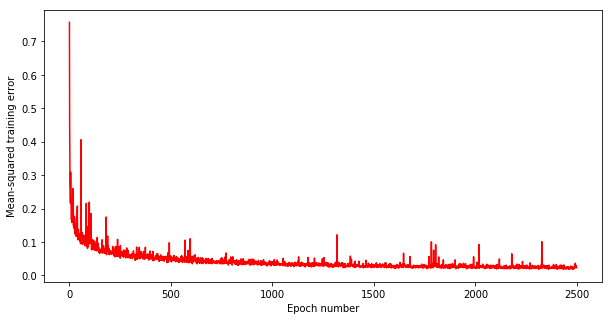

In [9]:
# Plot training error history
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r') 
plt.xlabel('Epoch number')
plt.ylabel('Mean-squared training error')

### Performance of prediction accuracy

Generate predictions for training and test sets

In [10]:
ts_train_truth = ts[lag:train_length]
ts_train_pred_object = forecaster.predict(ts_train)
ts_train_pred_mean = ts_train_pred_object['mean']
ts_train_pred_samples = ts_train_pred_object['samples']

ts_test_truth = ts[train_length:]
ts_test_pred_object = forecaster.predict(ts_test)
ts_test_pred_mean = ts_test_pred_object['mean']
ts_test_pred_samples = ts_test_pred_object['samples']

Calculate accuracy metrics:

MAPE -- Mean Absolute Percentage Error  

SMAPE -- Symmetric Mean Absolute Percentage Error

MASE -- Mean Absolute Scaled Error

In [11]:
metric_list = ['mape', 'smape', 'mase']
#metric_list = 'mape'

In [12]:
print('TRAIN:')
accuracy_train = print_model_performance_mean_accuracy(ts_train_pred_mean, ts_train_truth, metric_list,freq, ts_train)
print('TEST:')
accuracy_test = print_model_performance_mean_accuracy(ts_test_pred_mean, ts_test_truth, metric_list,freq, ts_train)

TRAIN:
	 Mean Absolute Percentage Error: 4.2%
	 Symmetric Mean Absolute Percentage Error: 4.0%
	 Mean Absolute Scaled Error: 20.7%
TEST:
	 Mean Absolute Percentage Error: 14.2%
	 Symmetric Mean Absolute Percentage Error: 14.2%
	 Mean Absolute Scaled Error: 113.6%


In [13]:
DataFrame(np.array([accuracy_train, accuracy_test]).T, index=[metric_list],columns=['Train','Test'])

,Train,Test
mape,4.206339,14.188321
smape,4.036663,14.161499
mase,20.739360,113.578386


### Performance of prediction uncertainty

Calculate Uncertainty metrics:

MSIS -- Mean Scaled Interval Score

Coverage of prediction intervals

In [14]:
metric_list = ['msis', 'coverage']
print('TRAIN:')
uncertainty_train = print_model_performance_uncertainty(ts_train_pred_samples, ts_train_truth, metric_list, 
                                                        freq, 0.95, ts_train)
print('TEST:')
uncertainty_test = print_model_performance_uncertainty(ts_test_pred_samples, ts_test_truth, metric_list, 
                                                        freq, 0.95, ts_train)

TRAIN:
	 Mean Scaled Interval Score at 95% confidence level: 184.4%
	 Coverage Percentage at 95% confidence level: 99.8%
TEST:
	 Mean Scaled Interval Score at 95% confidence level: 1963.9%
	 Coverage Percentage at 95% confidence level: 52.3%


### Create Calibration plot of prediction uncertainty: 
Measure coverage percentage at various specified confidence levels

In [15]:
metric_list = 'coverage'

In [16]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [17]:
confidence_level = list(frange(0.1, 1.0, 0.01))

In [18]:
uncertainty_train = print_model_performance_uncertainty(ts_train_pred_samples, ts_train_truth, metric_list, 
                                                        freq, confidence_level, ts_train, verbose=False)
uncertainty_test = print_model_performance_uncertainty(ts_test_pred_samples, ts_test_truth, metric_list, 
                                                        freq, confidence_level, ts_train, verbose=False)

In [19]:
confidence_level_int = np.array(confidence_level)*100

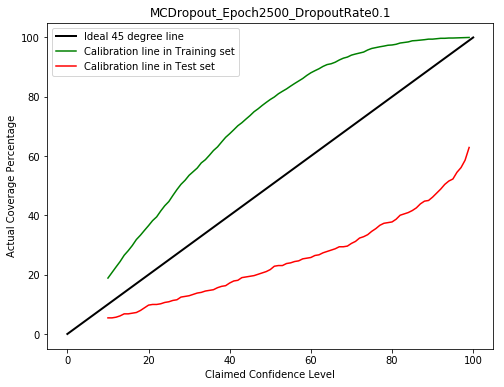

In [20]:
plt.figure(figsize=(8,6))
plt.plot([0, 100], [0, 100], 'k-', lw=2, label='Ideal 45 degree line')
plt.plot(confidence_level_int, uncertainty_train, 'g', label='Calibration line in Training set') 
plt.plot(confidence_level_int, uncertainty_test, 'r', label='Calibration line in Test set') 
plt.xlabel('Claimed Confidence Level')
plt.ylabel('Actual Coverage Percentage')
plt.legend(loc='upper left')

title = 'MCDropout_Epoch'+str(epoch)+'_DropoutRate'+str(dropout_rate)
plt.title(title)
plt.savefig(title+".png")

### Visualization of prediction with uncertainty

In [21]:
ts_pred = forecaster.predict(ts_test, n_samples=100)
ts_pred_mean = ts_pred['mean']
ts_pred_median = ts_pred['median']
ts_pred_upper_quantile = ts_pred['upper_quantile']
ts_pred_lower_quantile = ts_pred['lower_quantile']
ts_pred_samples = ts_pred['samples']

Plot of prediction samples of test set including uncertainty bounds

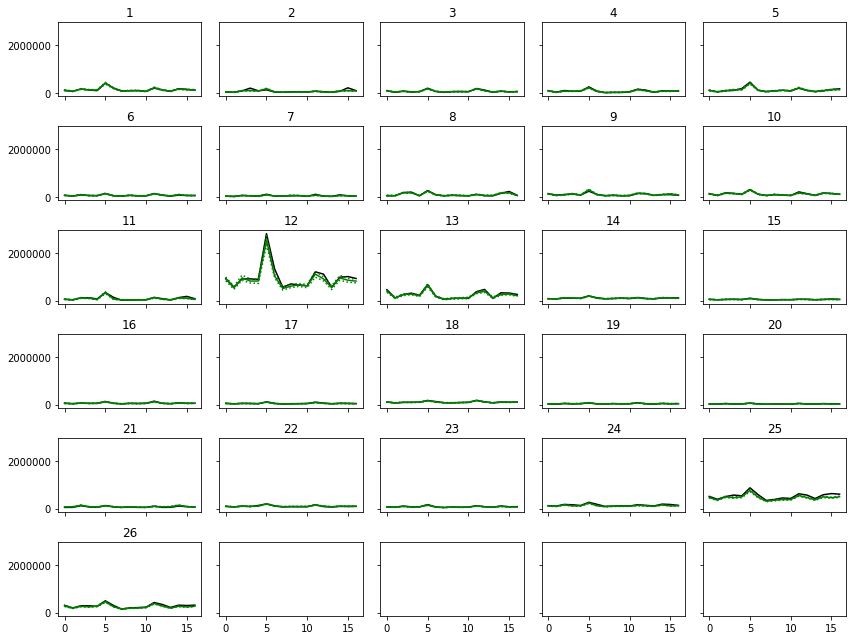

In [22]:
ncols = 5
fig, axes = plt.subplots(nrows=26//ncols+1, ncols=ncols, sharex=True, sharey=True, figsize=(12, 9))
for ax, ya, yp, yp_upper, yp_lower, title in zip(axes.flat, 
                                                 ts[train_length:,:,0].T, 
                                                 ts_pred_mean[:,:,0].T, 
                                                 ts_pred_upper_quantile[:,:,0].T, 
                                                 ts_pred_lower_quantile[:,:,0].T, 
                                                 range(1,26+1)):
    ax.plot(ya, 'k-')
    ax.plot(yp, 'g-')
    ax.plot(yp_lower, 'g:')
    ax.plot(yp_upper, 'g:')
    ax.set_title(title)

plt.tight_layout()